## Imports and Cleaning

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
!cd ~/Documents/Data_Projects/COVID/COVID-19

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

import statsmodels.api as sm
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import interpolate

from data_clean import *
from model_helper import *
%load_ext autoreload
%autoreload 2

In [3]:
# Read in live data (countries from Johns Hopkins, states + count)
countries = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
local = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

testing = pd.read_json('https://covidtracking.com/api/v1/states/daily.json')

In [4]:
df_country = clean_data_hopkins(countries, country='all')
df_state = clean_data_nyt(states, level='state')
df_local = clean_data_nyt(local, level='local')

df_testing = clean_data_trackingproject(testing)

/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/anaconda3/envs/covid/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_testing.loc[df_testing.State.isin(['NY'])].tail(3)

,State,Date,Positive,Negative,Pending,HospitalizedCurrently,HospitalizedCumulative,InIcuCurrently,InIcuCumulative,OnVentilatorCurrently,OnVentilatorCumulative,Recovered,Death,Hospitalized,Total,TotalTestResults,PosNeg,DeathIncrease,HospitalizedIncrease,NegativeIncrease,PositiveIncrease,TotalTestResultsIncrease
1506,NY,2020-04-12,188694.0,272907.0,NaN,18707.0,42594.0,5198.0,NaN,NaN,NaN,23887.0,9385.0,42594.0,461601.0,461601.0,461601.0,758.0,1915.0,12385.0,8236.0,20621.0
1507,NY,2020-04-13,195031.0,283326.0,NaN,18825.0,42712.0,5156.0,NaN,NaN,NaN,23887.0,10056.0,42712.0,478357.0,478357.0,478357.0,671.0,118.0,10419.0,6337.0,16756.0
1508,NY,2020-04-14,202208.0,296935.0,NaN,18697.0,46201.0,5225.0,NaN,NaN,NaN,23887.0,10834.0,46201.0,499143.0,499143.0,499143.0,778.0,3489.0,13609.0,7177.0,20786.0


In [6]:
df_state.loc[df_state.State == 'New York'].tail(3)

,State,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
1450,New York,2020-04-11,180458,2020-03-03,40,9946.0,3.688879,12.103253,9.204926
1451,New York,2020-04-12,188694,2020-03-03,41,8236.0,3.713572,12.147882,9.016270
1452,New York,2020-04-13,195031,2020-03-03,42,6337.0,3.737670,12.180914,8.754161


In [7]:
US = df_country.loc[df_country.Country=='US']
US.tail(3)

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
15156,US,2020-04-12,555313,2020-01-24,80,28917.0,4.382027,13.227287,10.272185
15341,US,2020-04-13,580619,2020-01-24,81,25306.0,4.394449,13.271850,10.138797
15526,US,2020-04-14,607670,2020-01-24,82,27051.0,4.406719,13.317387,10.205479


## Regression of Actual Cases

In [8]:
US_trimmed = US[US.Date > pd.to_datetime('2020-03-01').date()]
US_trimmed.head(3)

,Country,Date,Confirmed,EpidemicStartDate,DaysElapsed,NewConfirmed,DaysElapsed_Log,Confirmed_Log,NewConfirmed_Log
7571,US,2020-03-02,98,2020-01-24,39,24.0,3.663562,4.584967,3.178054
7756,US,2020-03-03,118,2020-01-24,40,20.0,3.688879,4.770685,2.995732
7941,US,2020-03-04,149,2020-01-24,41,31.0,3.713572,5.003946,3.433987


### Fitting Exponential

In [9]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [10]:
# Regressing on last 14 days
params, covar = curve_fit(lambda t,a,b: a*np.exp(b*t),  x[-14:],  y[-14:], p0=(2,.1))
y_hat_scipy = params[0]*np.exp(params[1]*x)
r2_scipy = r2_score(y, y_hat_scipy)

In [11]:
# Unweighted Regression (Higher magnitudes of Y implicitly weighted higher)
params = np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
y_hat_numpy = np.exp(params[1]) * np.exp(params[0] * x)
r2_numpy = r2_score(y, y_hat_numpy)

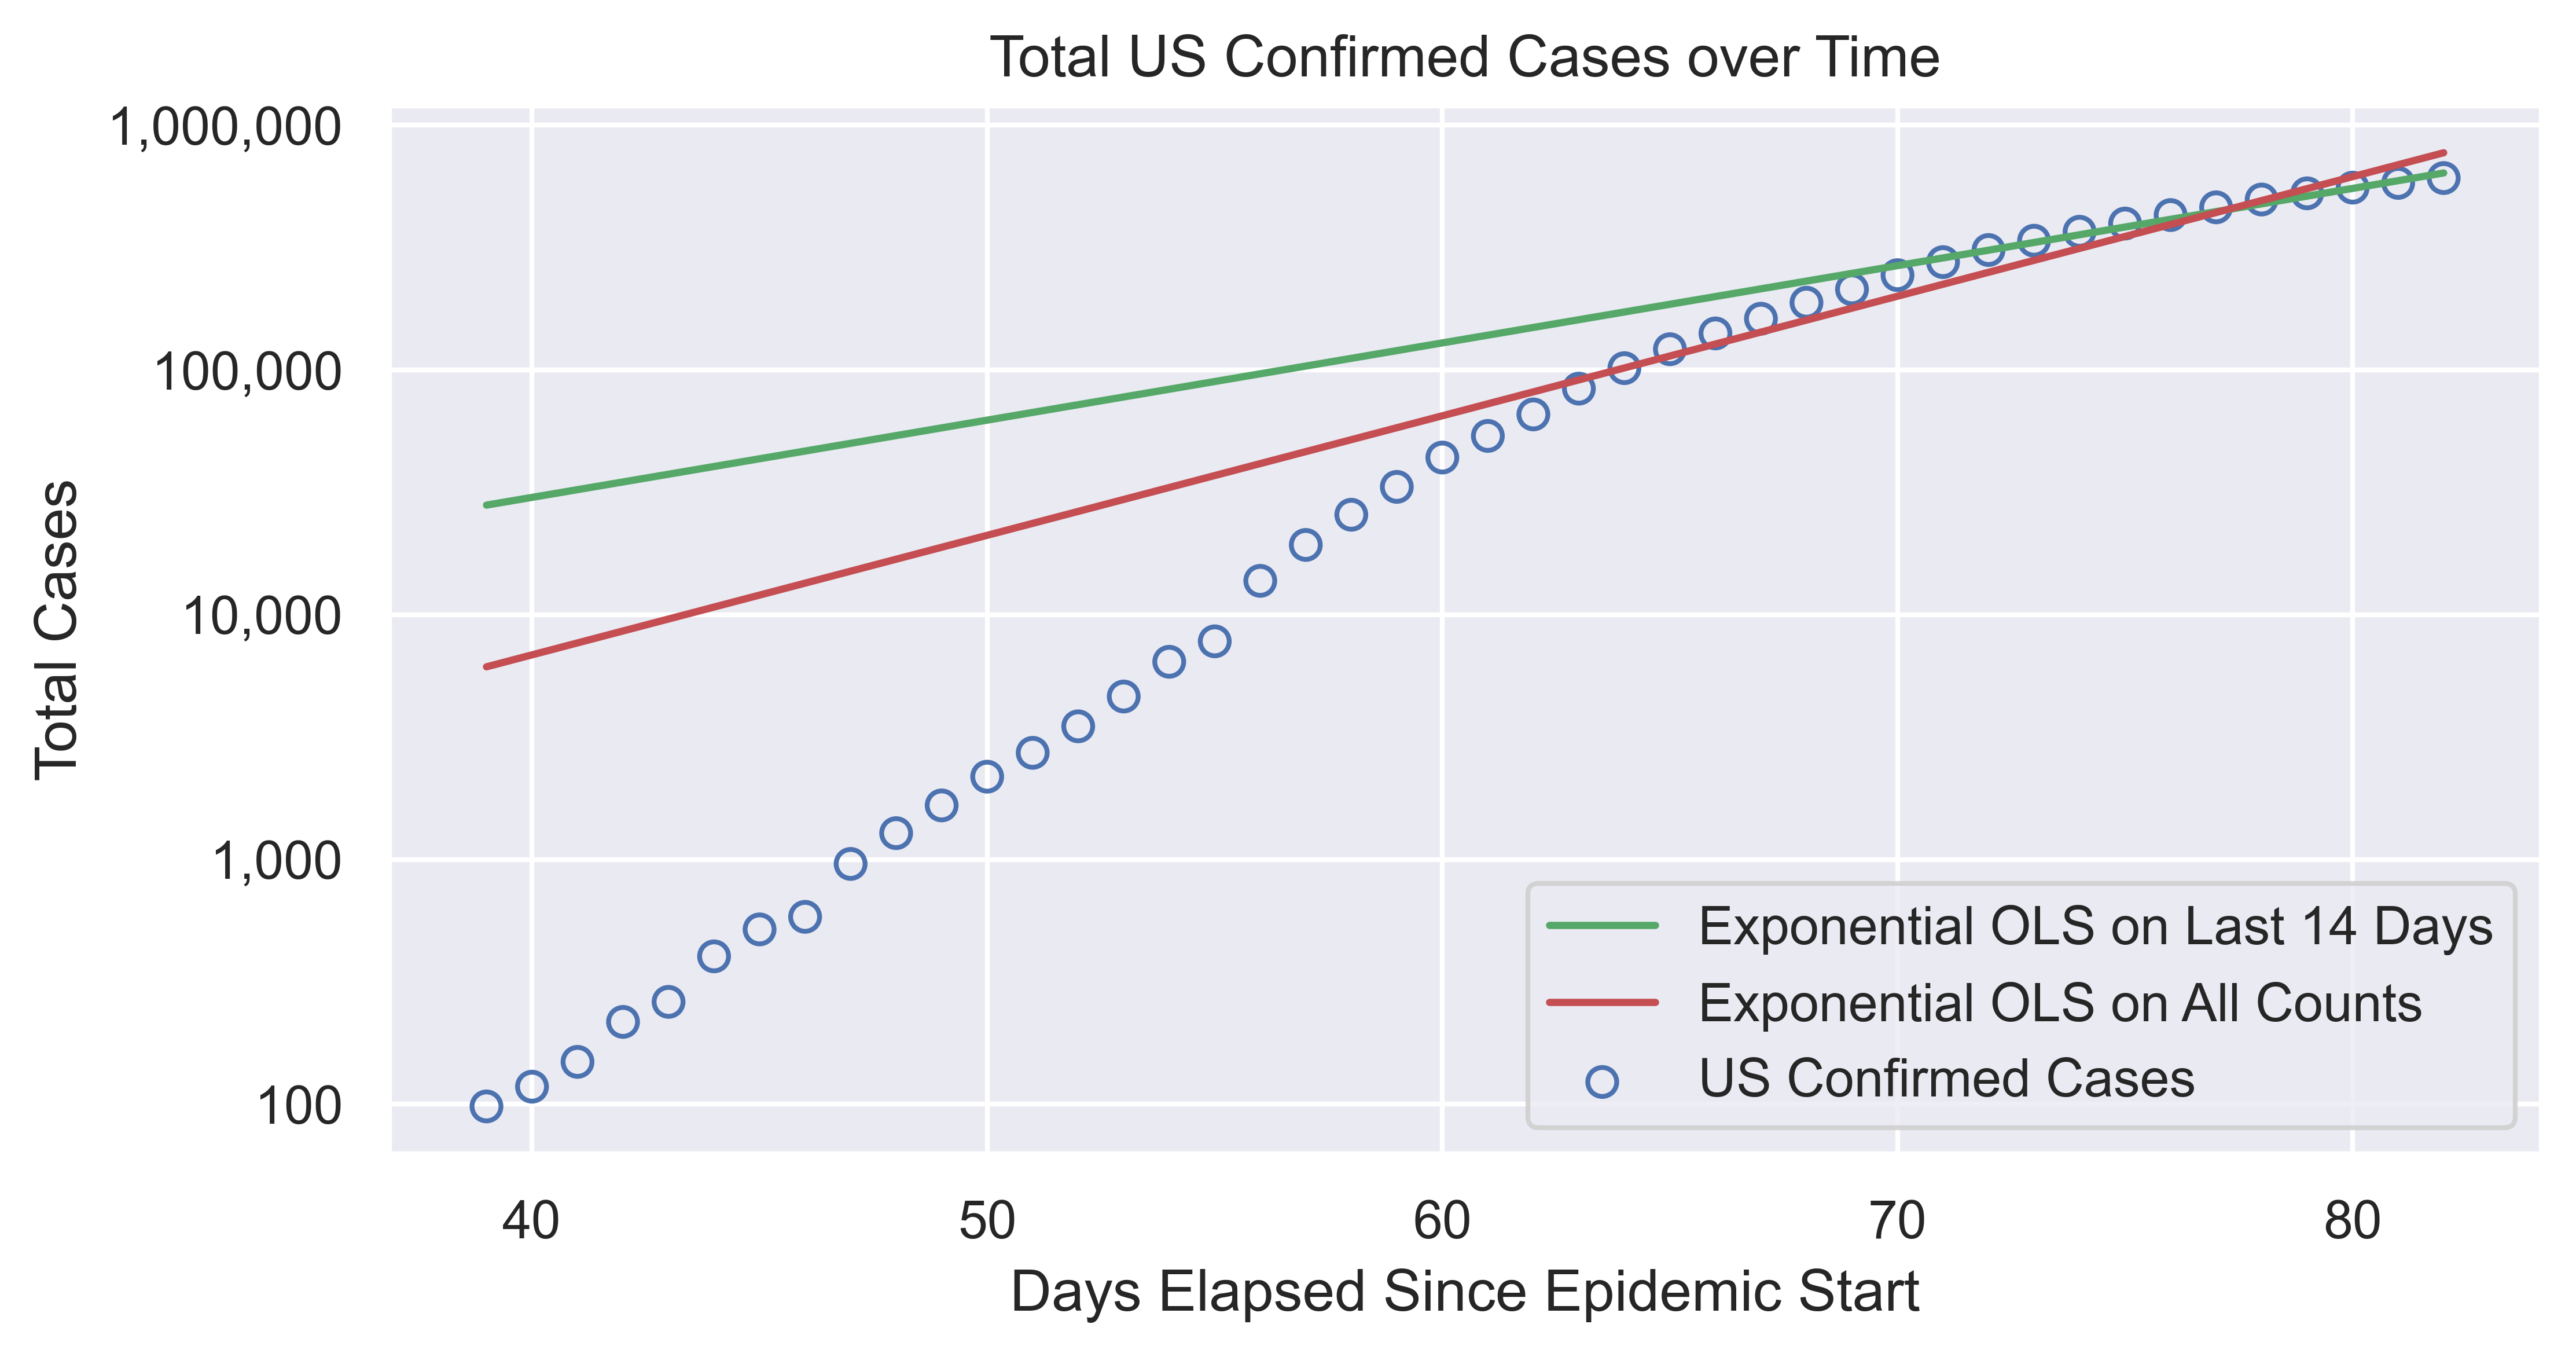

In [12]:
## Make this into log v unlogged side by side comparison
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, y, facecolors = 'none', edgecolor = 'b', label = 'US Confirmed Cases')
ax.plot(x, y_hat_scipy, '-', color = 'g', label = 'Exponential OLS on Last 14 Days')
ax.plot(x, y_hat_numpy, '-', color = 'r', label = 'Exponential OLS on All Counts')

plt.yscale('log') 
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Total Cases')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Total US Confirmed Cases over Time')
fig.show(warn=False)

### Using weighted local regression (LOWESS)

In [13]:
x = US_trimmed.DaysElapsed.values
y = US_trimmed.Confirmed.values

In [14]:
y_hat = sm.nonparametric.lowess(y, x, frac=7/len(x), it=0, return_sorted=False)

d = 3
x_range, y_pred = predict_lowess(x, y_hat, days=d, extend=False)

preds = pd.DataFrame(list(zip(x_range, np.around(y_pred,0))), columns =['DaysElapsed', 'Confirmed Predictions']) 
preds

,DaysElapsed,Confirmed Predictions
0,83,636273.0
1,84,663894.0
2,85,691515.0


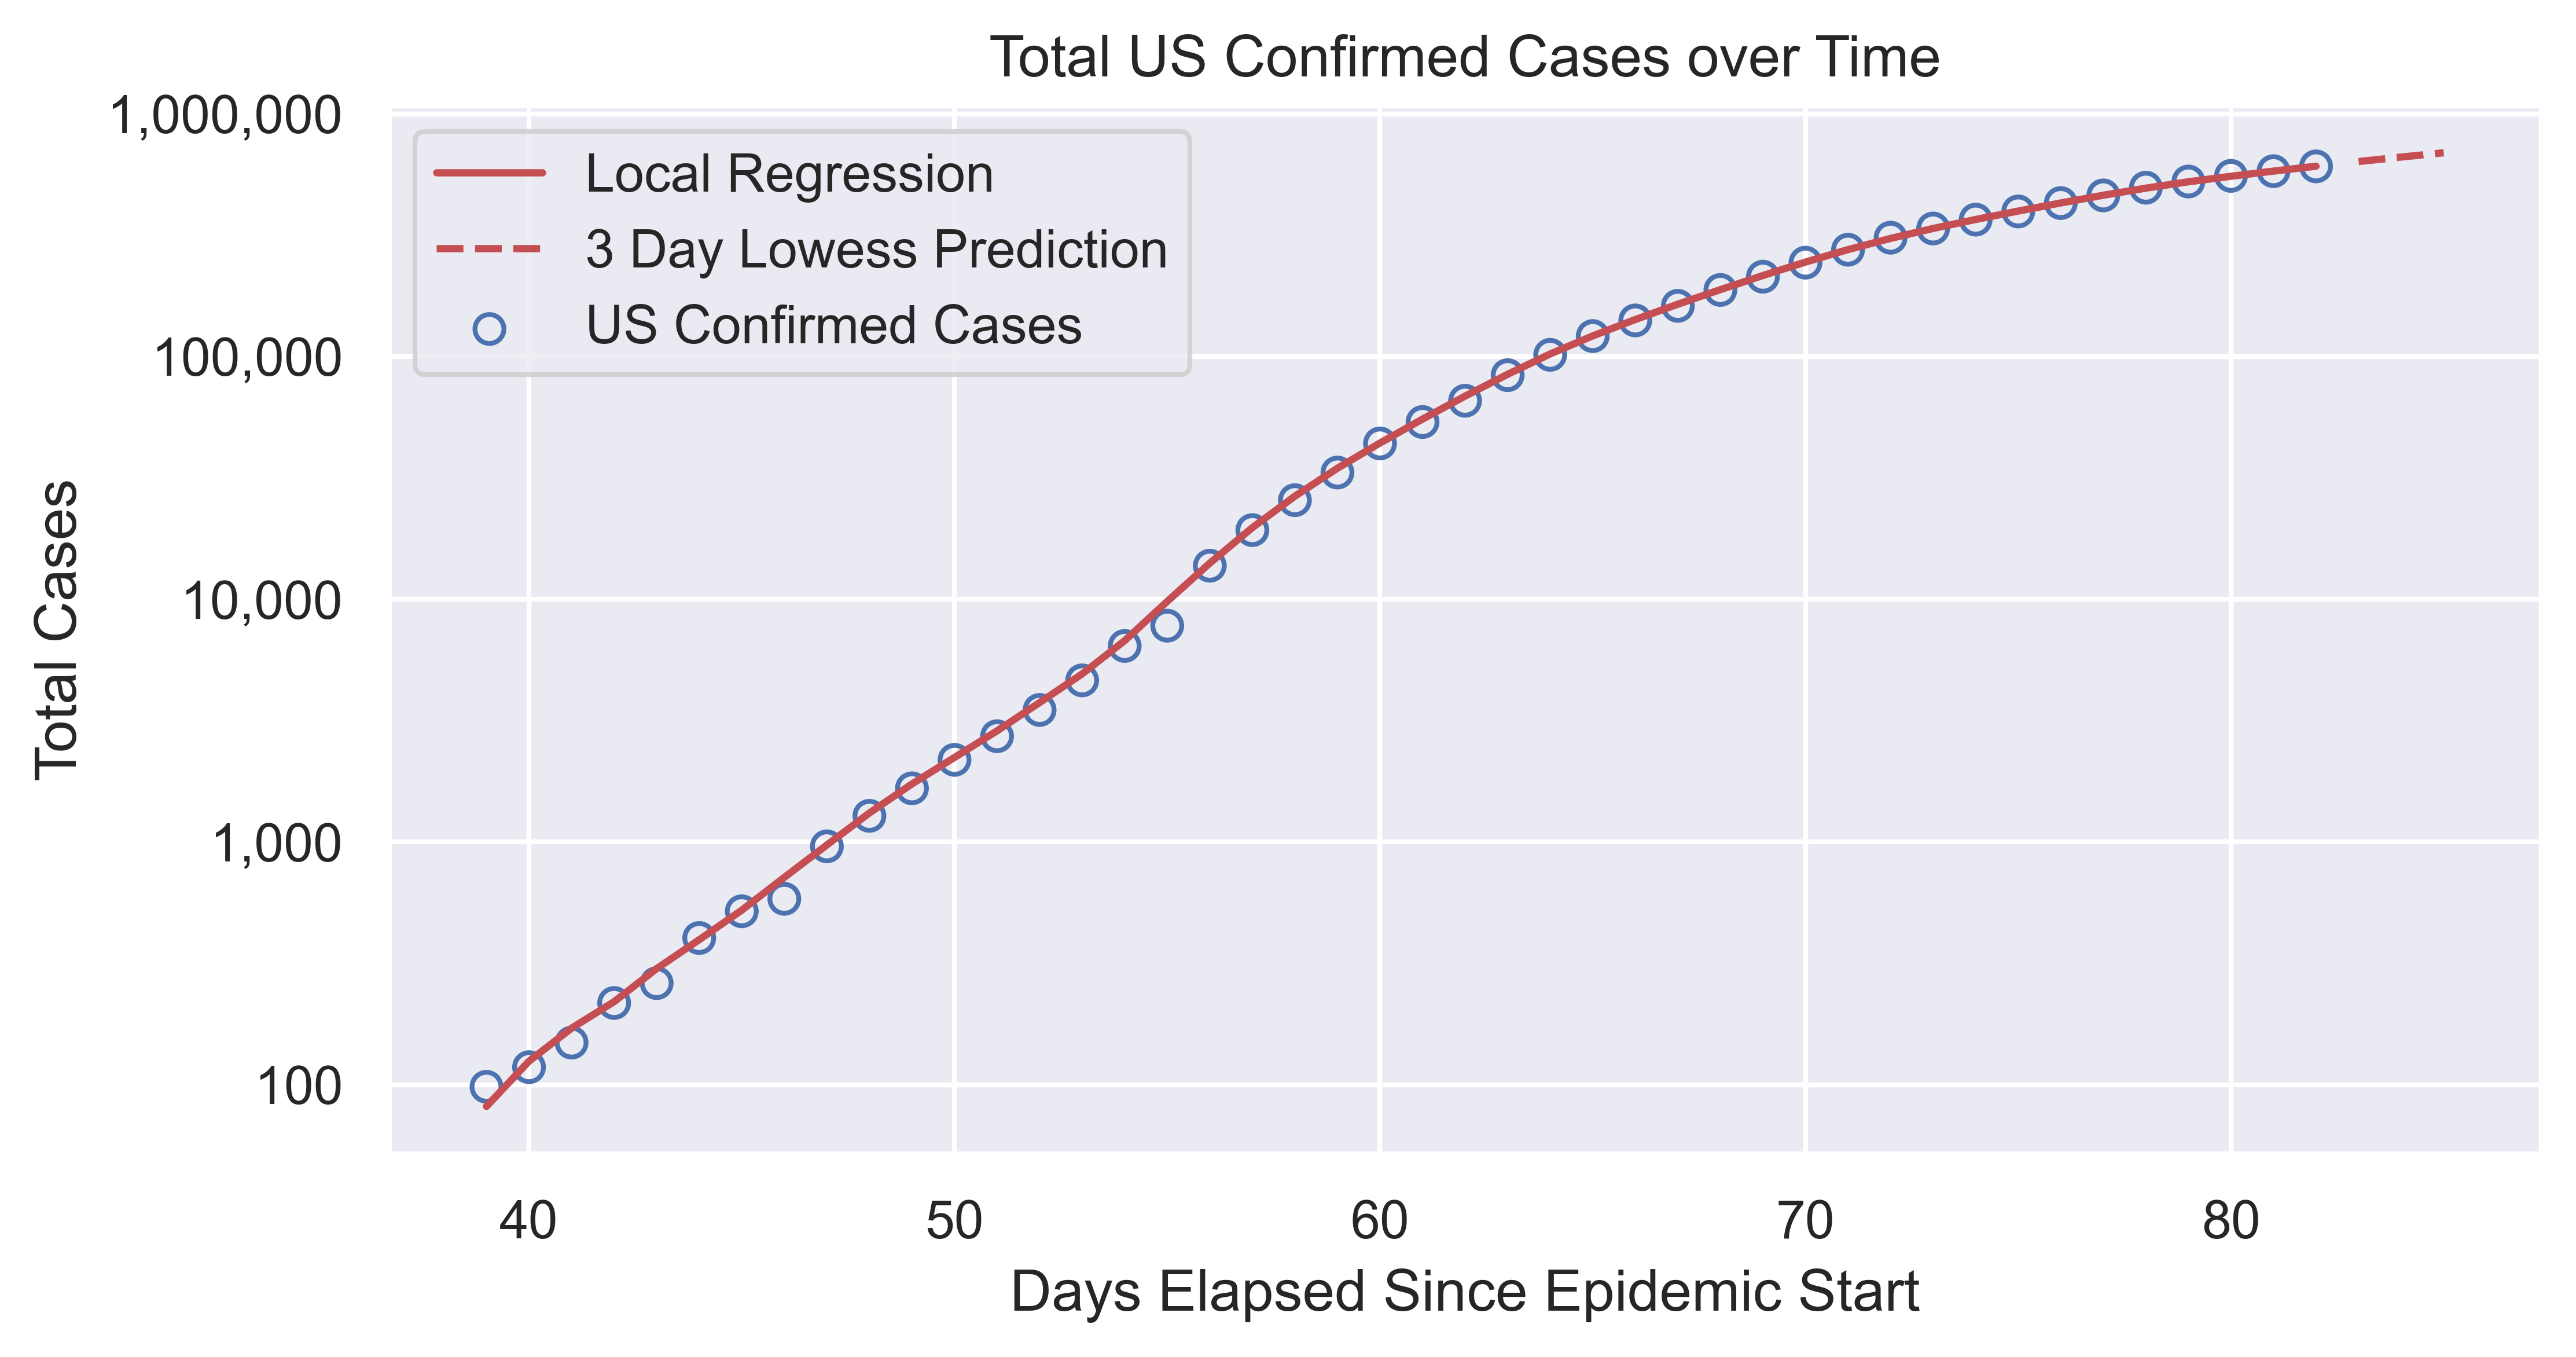

In [15]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, y, facecolors = 'none', edgecolor = 'b', label = 'US Confirmed Cases')
ax.plot(x, y_hat, color = 'r', label = 'Local Regression')

ax.plot(x_range, y_pred, '--', color = 'r', label = '{} Day Lowess Prediction'.format(d))

plt.yscale('log')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Total Cases')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Total US Confirmed Cases over Time')
fig.show(warn=False)

### Using compounded growth

Using the logarithmic approximation

In [16]:
x = US_trimmed.DaysElapsed.values[1:]
r = US_trimmed.Confirmed_Log.diff(periods=1).values[1:] 

In [17]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],r[-14:],deg=1)
r_hat = x*params[0]+params[1]

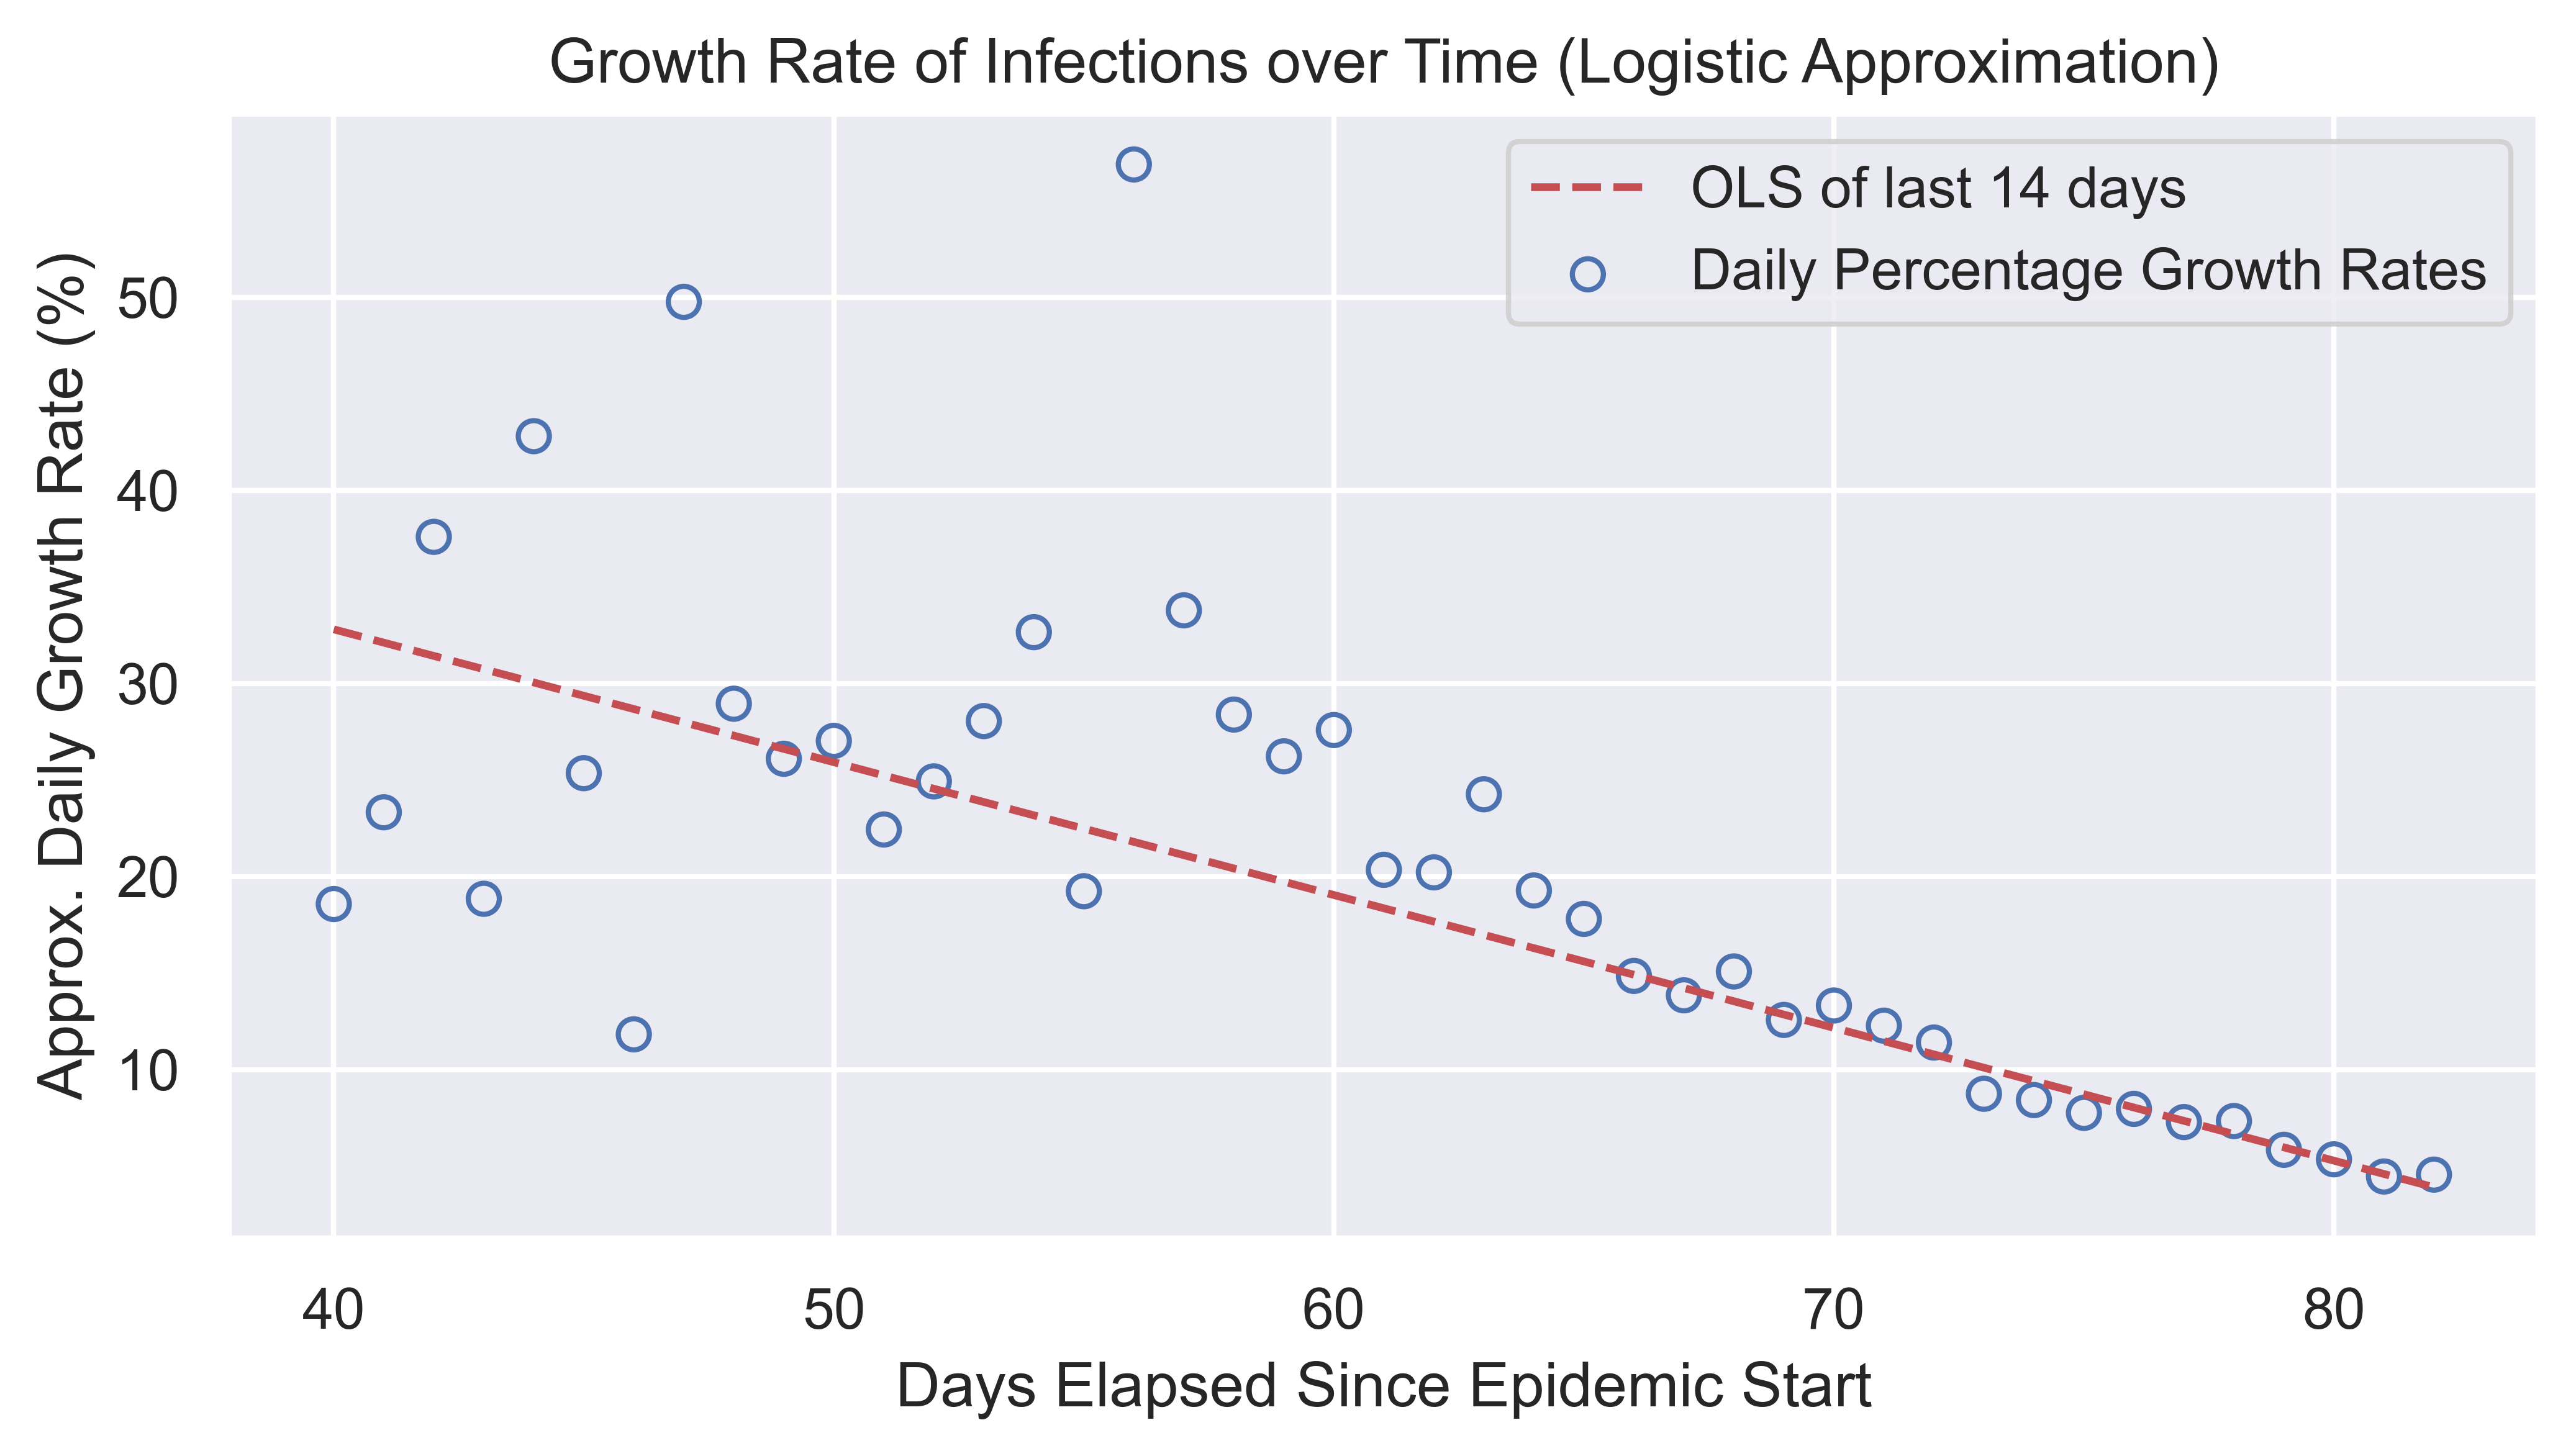

In [18]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, r*100, facecolors = 'none', edgecolor = 'b', label = 'Daily Percentage Growth Rates')
ax.plot(x, r_hat*100, '--', color = 'r', label = 'OLS of last 14 days')

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Approx. Daily Growth Rate (%)')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Growth Rate of Infections over Time (Logistic Approximation)')
fig.show(warn=False)

Using actual daily growth rate in confirmed cases

In [19]:
x = US_trimmed.DaysElapsed.values[1:]
r = (US_trimmed.Confirmed/US_trimmed.Confirmed.shift(1)).values[1:]
y = US_trimmed.Confirmed.values[1:]

In [20]:
# Only consider the last 2 weeks to regress on
params = np.polyfit(x[-14:],r[-14:],deg=1)
r_hat = x*params[0]+params[1]

r2_score(r[-14:], r_hat[-14:])

0.9344051468255086

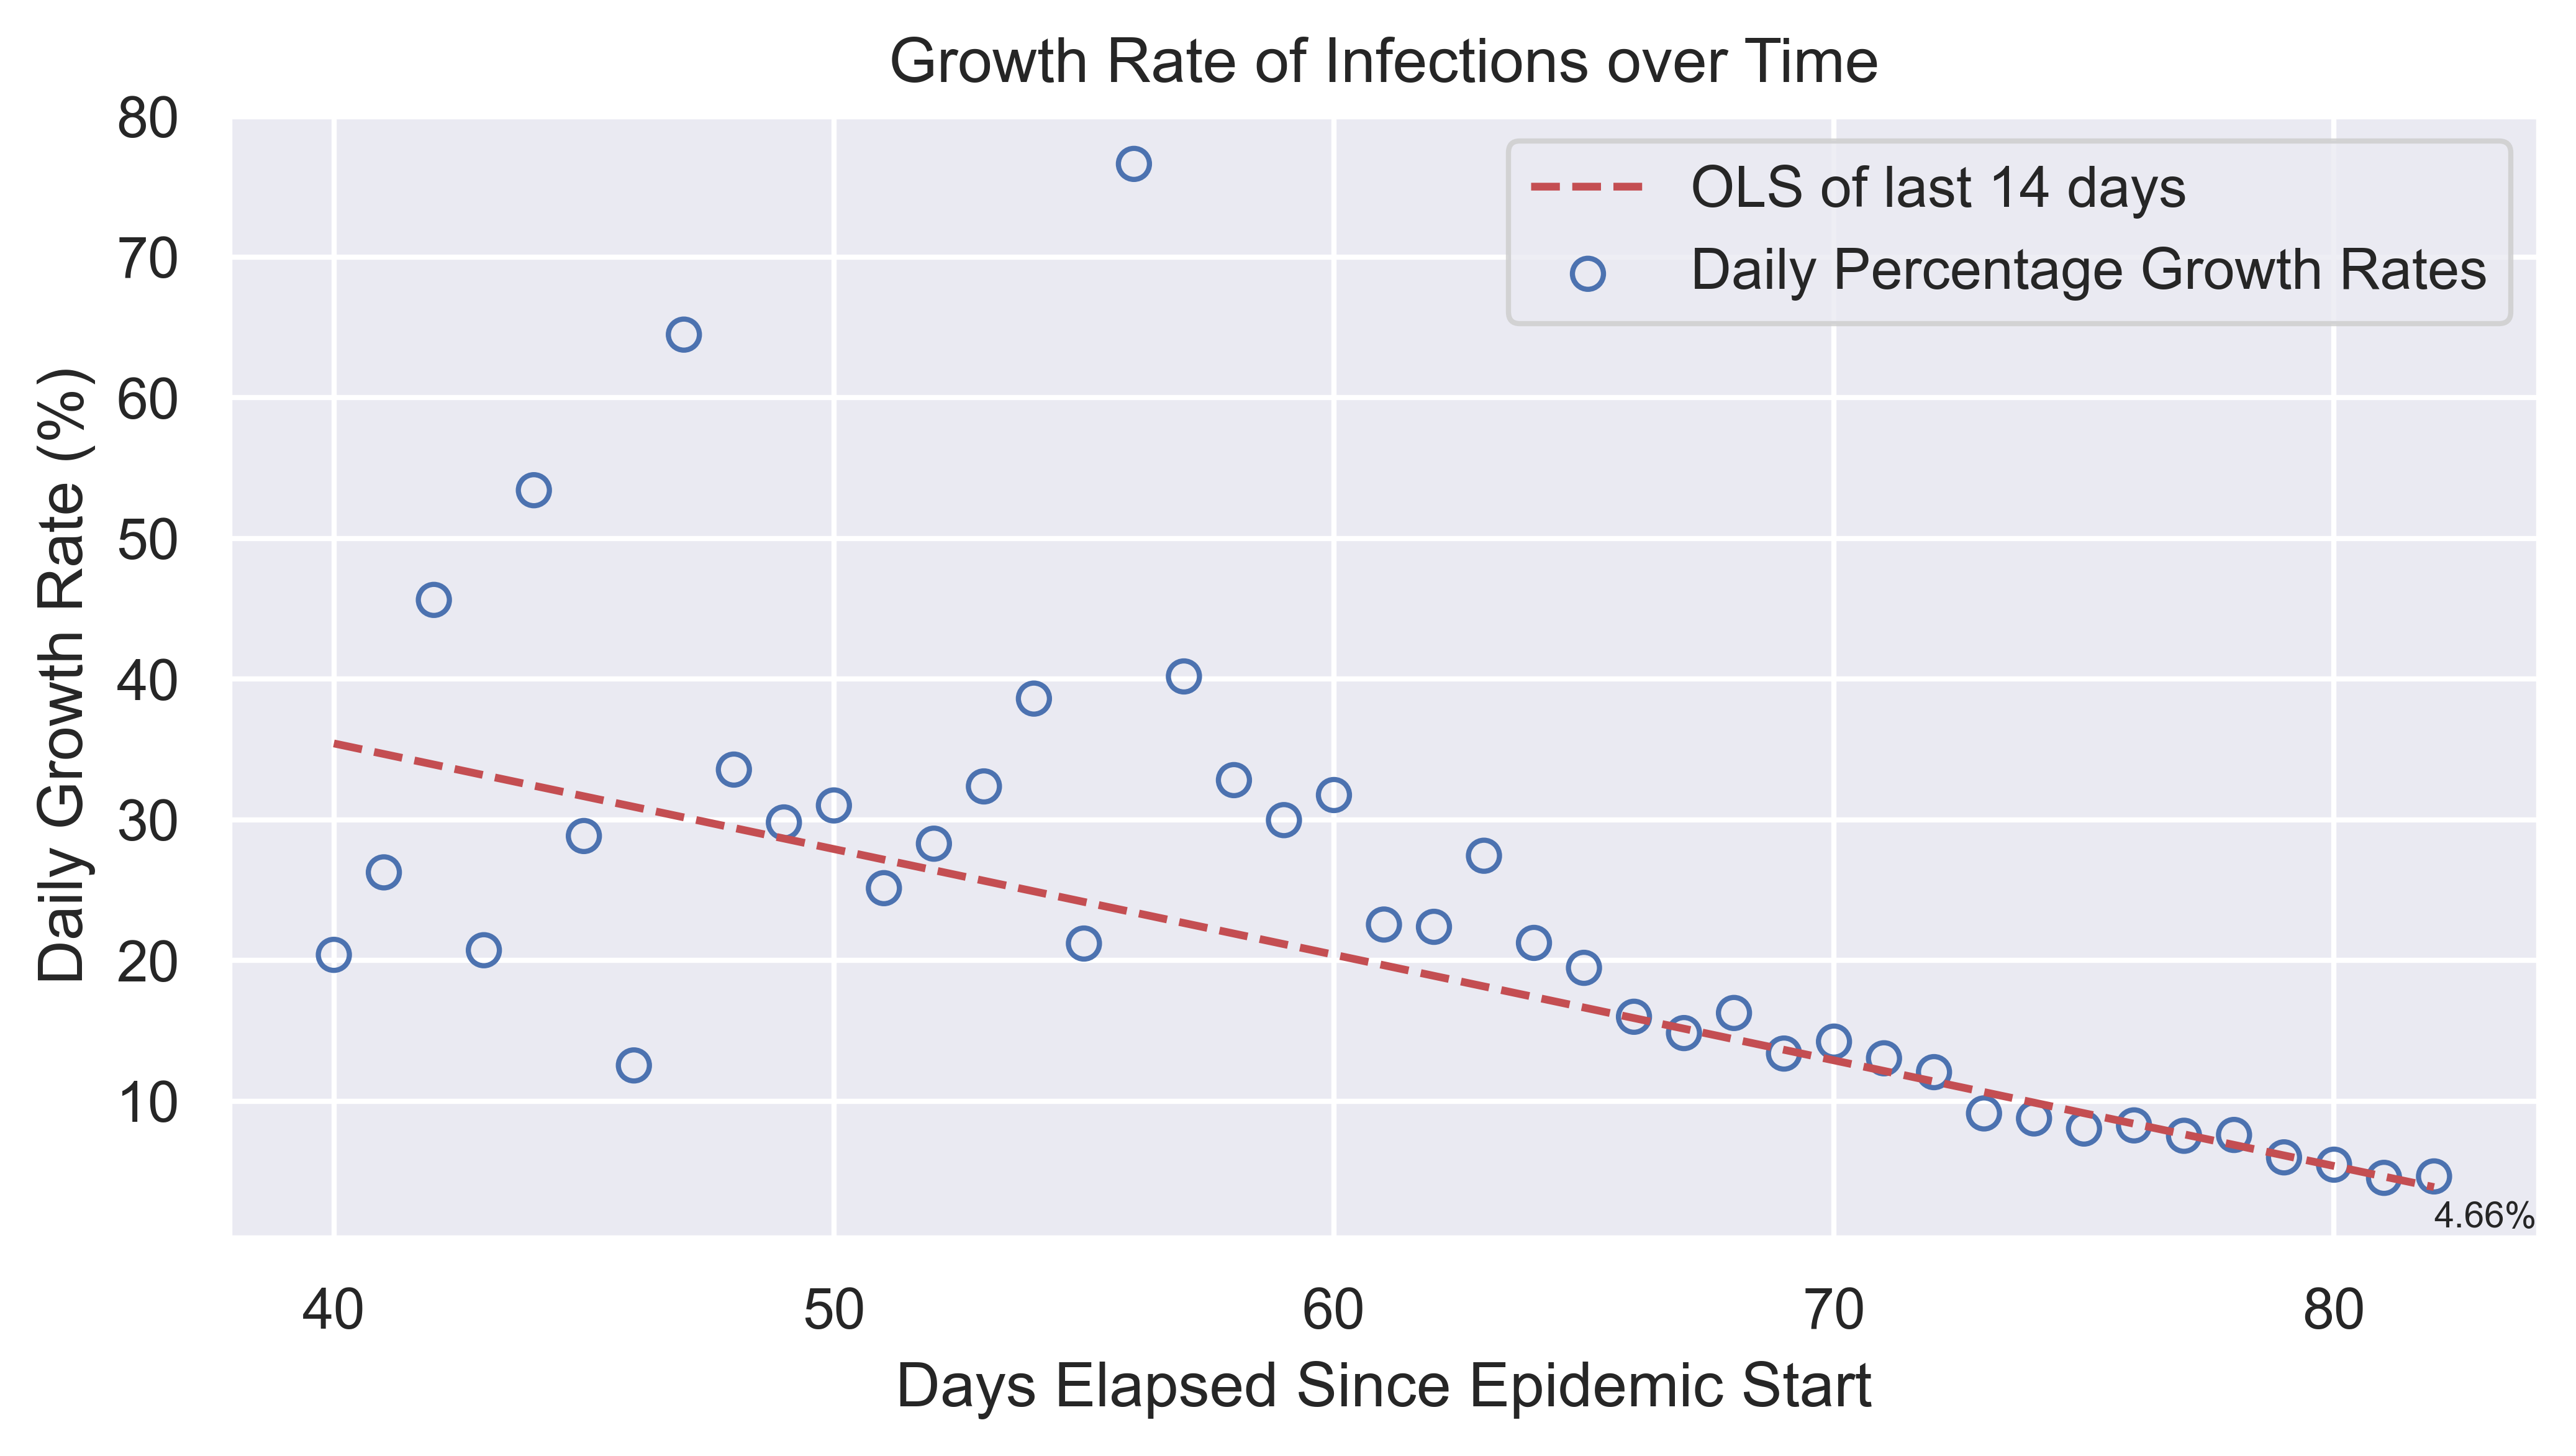

In [21]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(x, r*100-100, facecolors = 'none', edgecolor = 'b', label = 'Daily Percentage Growth Rates')
ax.plot(x, r_hat*100-100, '--', color = 'r', label = 'OLS of last 14 days')

ax.text(x=x[-1], y=r[-1], s=r'%2.2f'%(r[-1]*100-100)+'%', fontsize=7) 

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Daily Growth Rate (%)')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Growth Rate of Infections over Time')
fig.show(warn=False)

In [29]:
# Predict cases from growth rate
x_range, y_pred, r_pred = predict_growth(x, y, r, params, days=3)
preds = pd.DataFrame({'DaysElapsed':x_range, 'ConfirmedPred':y_pred, 'GrowthRatePred':r_pred})
preds

,DaysElapsed,ConfirmedPred,GrowthRatePred
0,83,635981.304263,1.031470
1,84,655995.874724,1.023961
2,85,671714.502044,1.016453


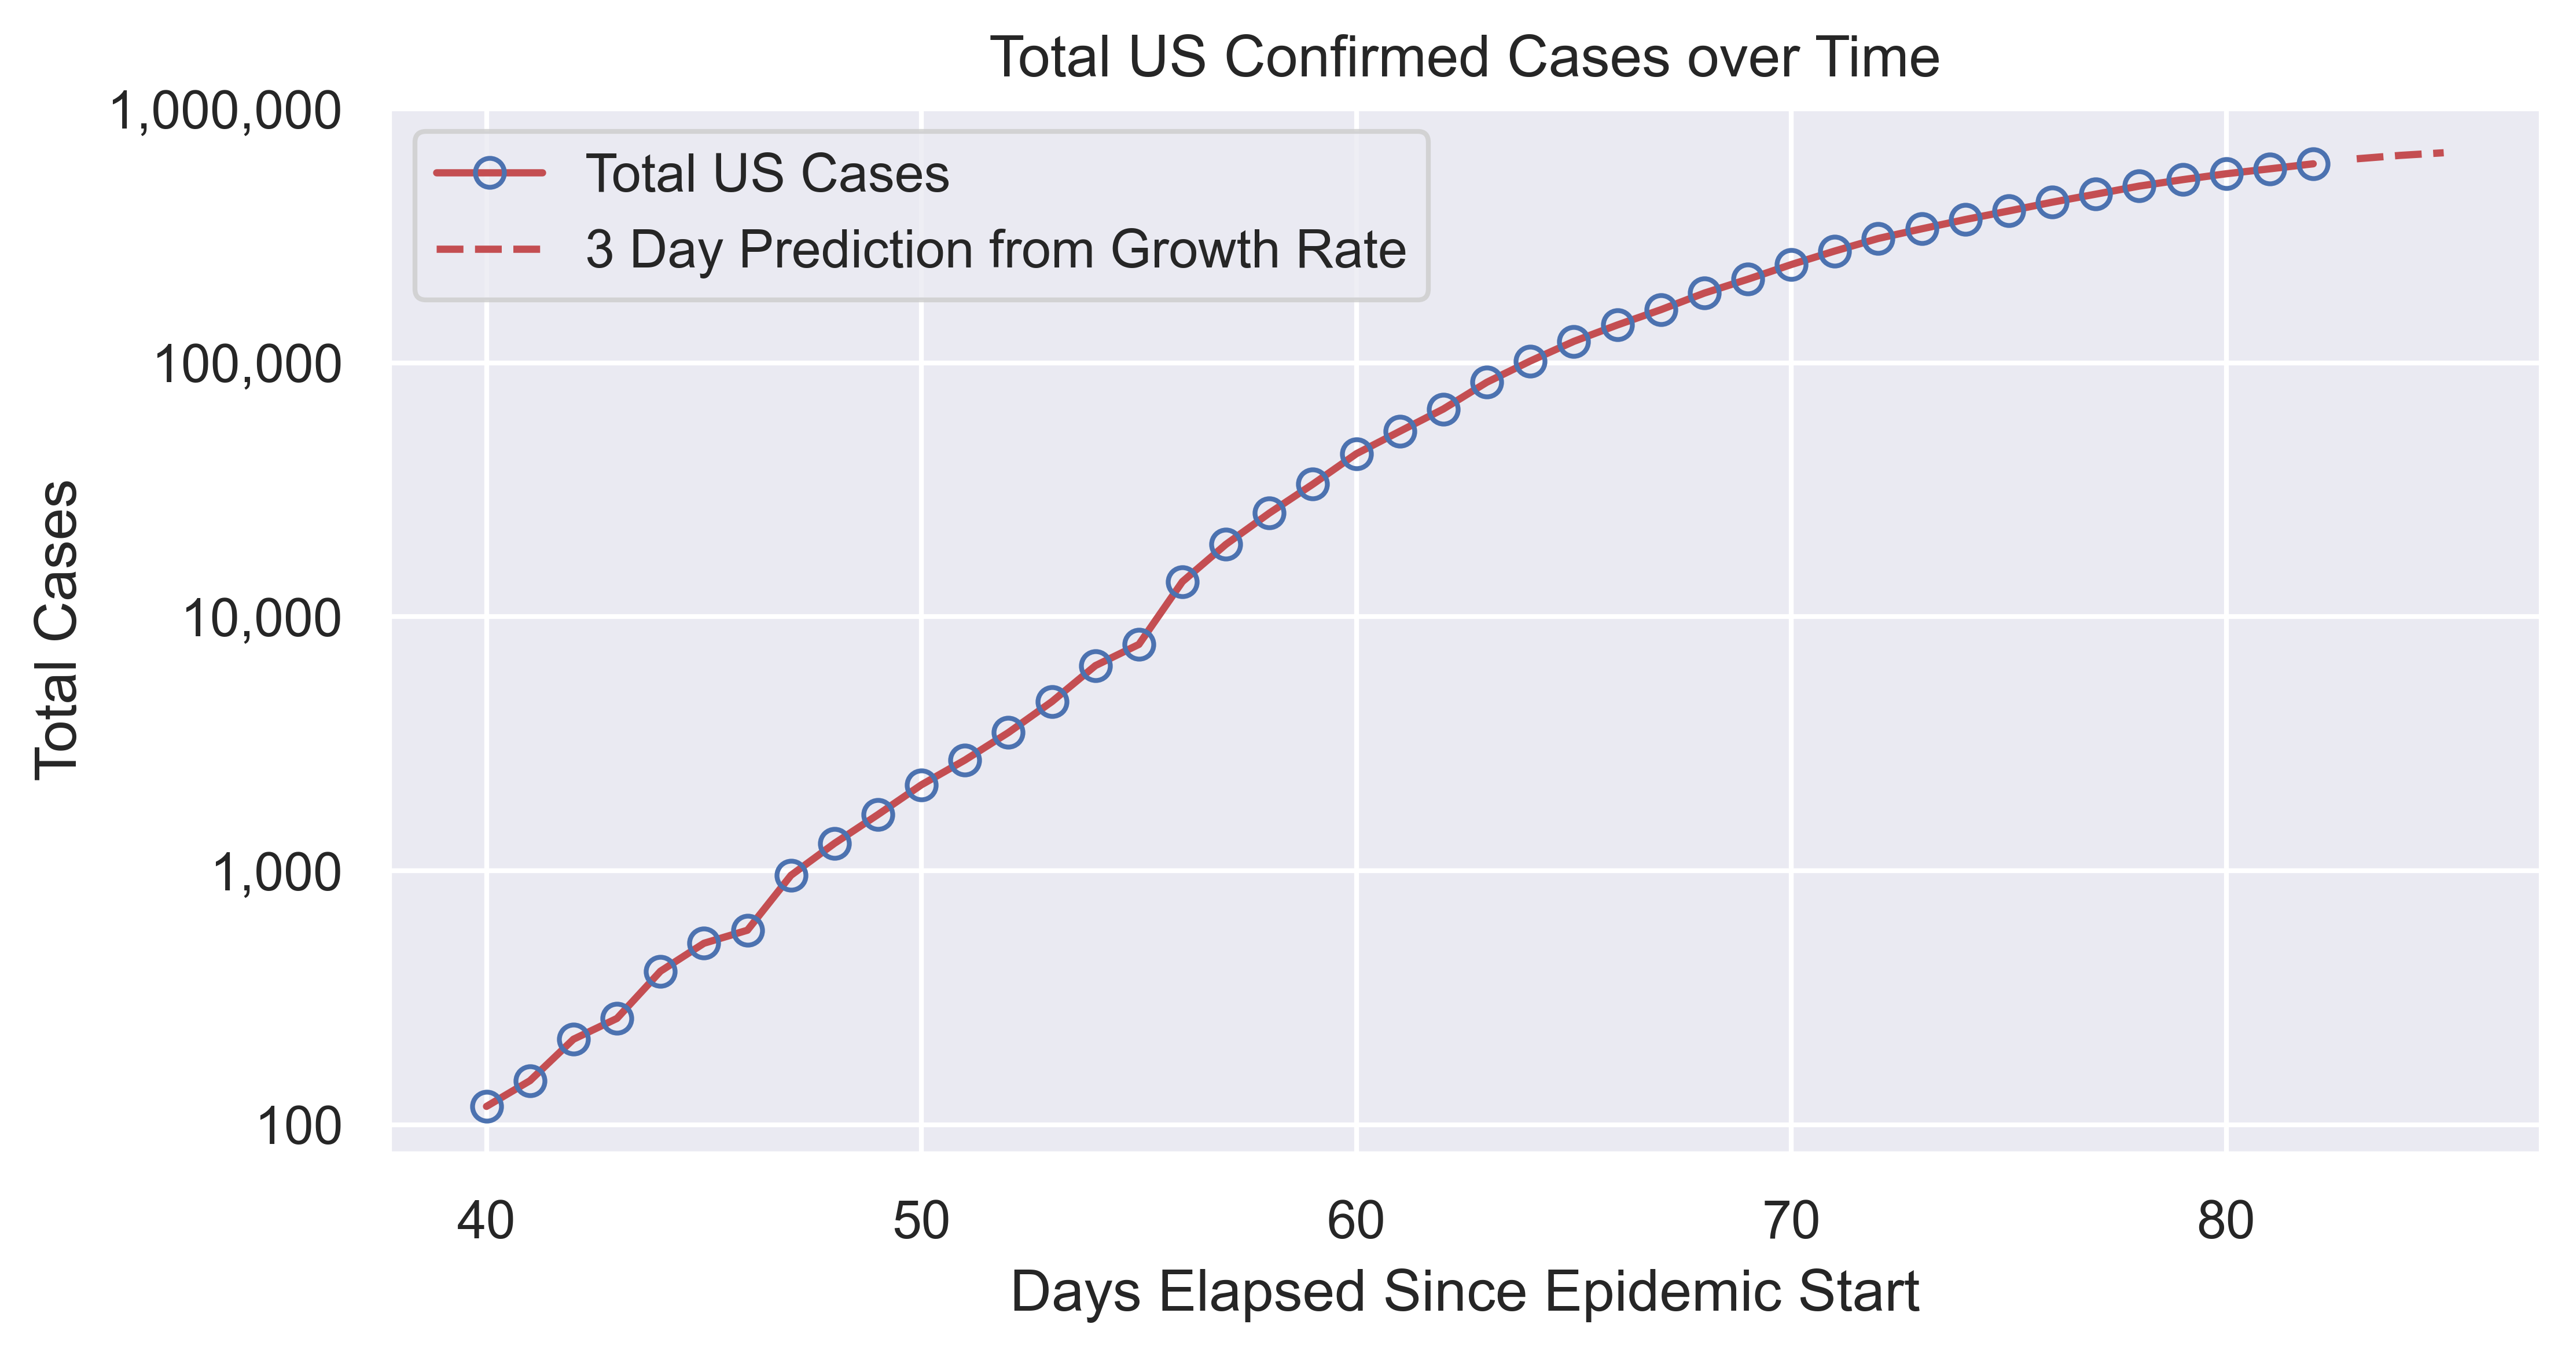

In [23]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.plot(x, y, 'o-', markerfacecolor = 'none', markeredgecolor = 'b', color='r', label = 'Total US Cases')
ax.plot(x_range, y_pred, '--', color = 'r', label = '{} Day Prediction from Growth Rate'.format(d))

plt.yscale('log')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Total Cases')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Total US Confirmed Cases over Time')
fig.show(warn=False)

### Regressing Logistic

Adapted from https://www.kaggle.com/lucaalbrizzo/robusteness-fits-and-mortality-rates-for-covid-19

In [24]:
from lmfit.models import ExponentialModel

model_exp = ExponentialModel()
params_exp = model_exp.guess(US_trimmed.Confirmed, x=US_trimmed.DaysElapsed)
result_exp = model_exp.fit(US_trimmed.Confirmed, params_exp, x=US_trimmed.DaysElapsed)

result_exp.params

name,value,standard error,relative error,initial value,min,max,vary
amplitude,235.561101,74.0529091,(31.44%),0.0438428572855341,-inf,inf,True
decay,-10.2717344,0.42801098,(4.17%),-4.617757892606159,-inf,inf,True


In [25]:
from lmfit.models import StepModel

model_log = StepModel(form='logistic')
params_log = model_log.guess(US_trimmed.Confirmed, x=US_trimmed.DaysElapsed)
result_log = model_log.fit(US_trimmed.Confirmed, params_log, x=US_trimmed.DaysElapsed)

result_log.params

name,value,standard error,relative error,initial value,min,max,vary
amplitude,714882.252,12025.6804,(1.68%),607572,-inf,inf,True
center,73.5968233,0.21995438,(0.30%),60.5,-inf,inf,True
sigma,5.18533019,0.10147245,(1.96%),6.142857142857143,0.00000000,inf,True


In [26]:
x_range = np.arange(US_trimmed.DaysElapsed.iloc[-1]+1, US_trimmed.DaysElapsed.iloc[-1]+1+3)
y_pred = model_log.eval(result_log.params, x=x_range)

preds = pd.DataFrame(list(zip(x_range, np.around(y_pred,0))), columns =['DaysElapsed', 'Confirmed Predictions']) 
preds

,DaysElapsed,Confirmed Predictions
0,83,614638.0
1,84,630136.0
2,85,643516.0


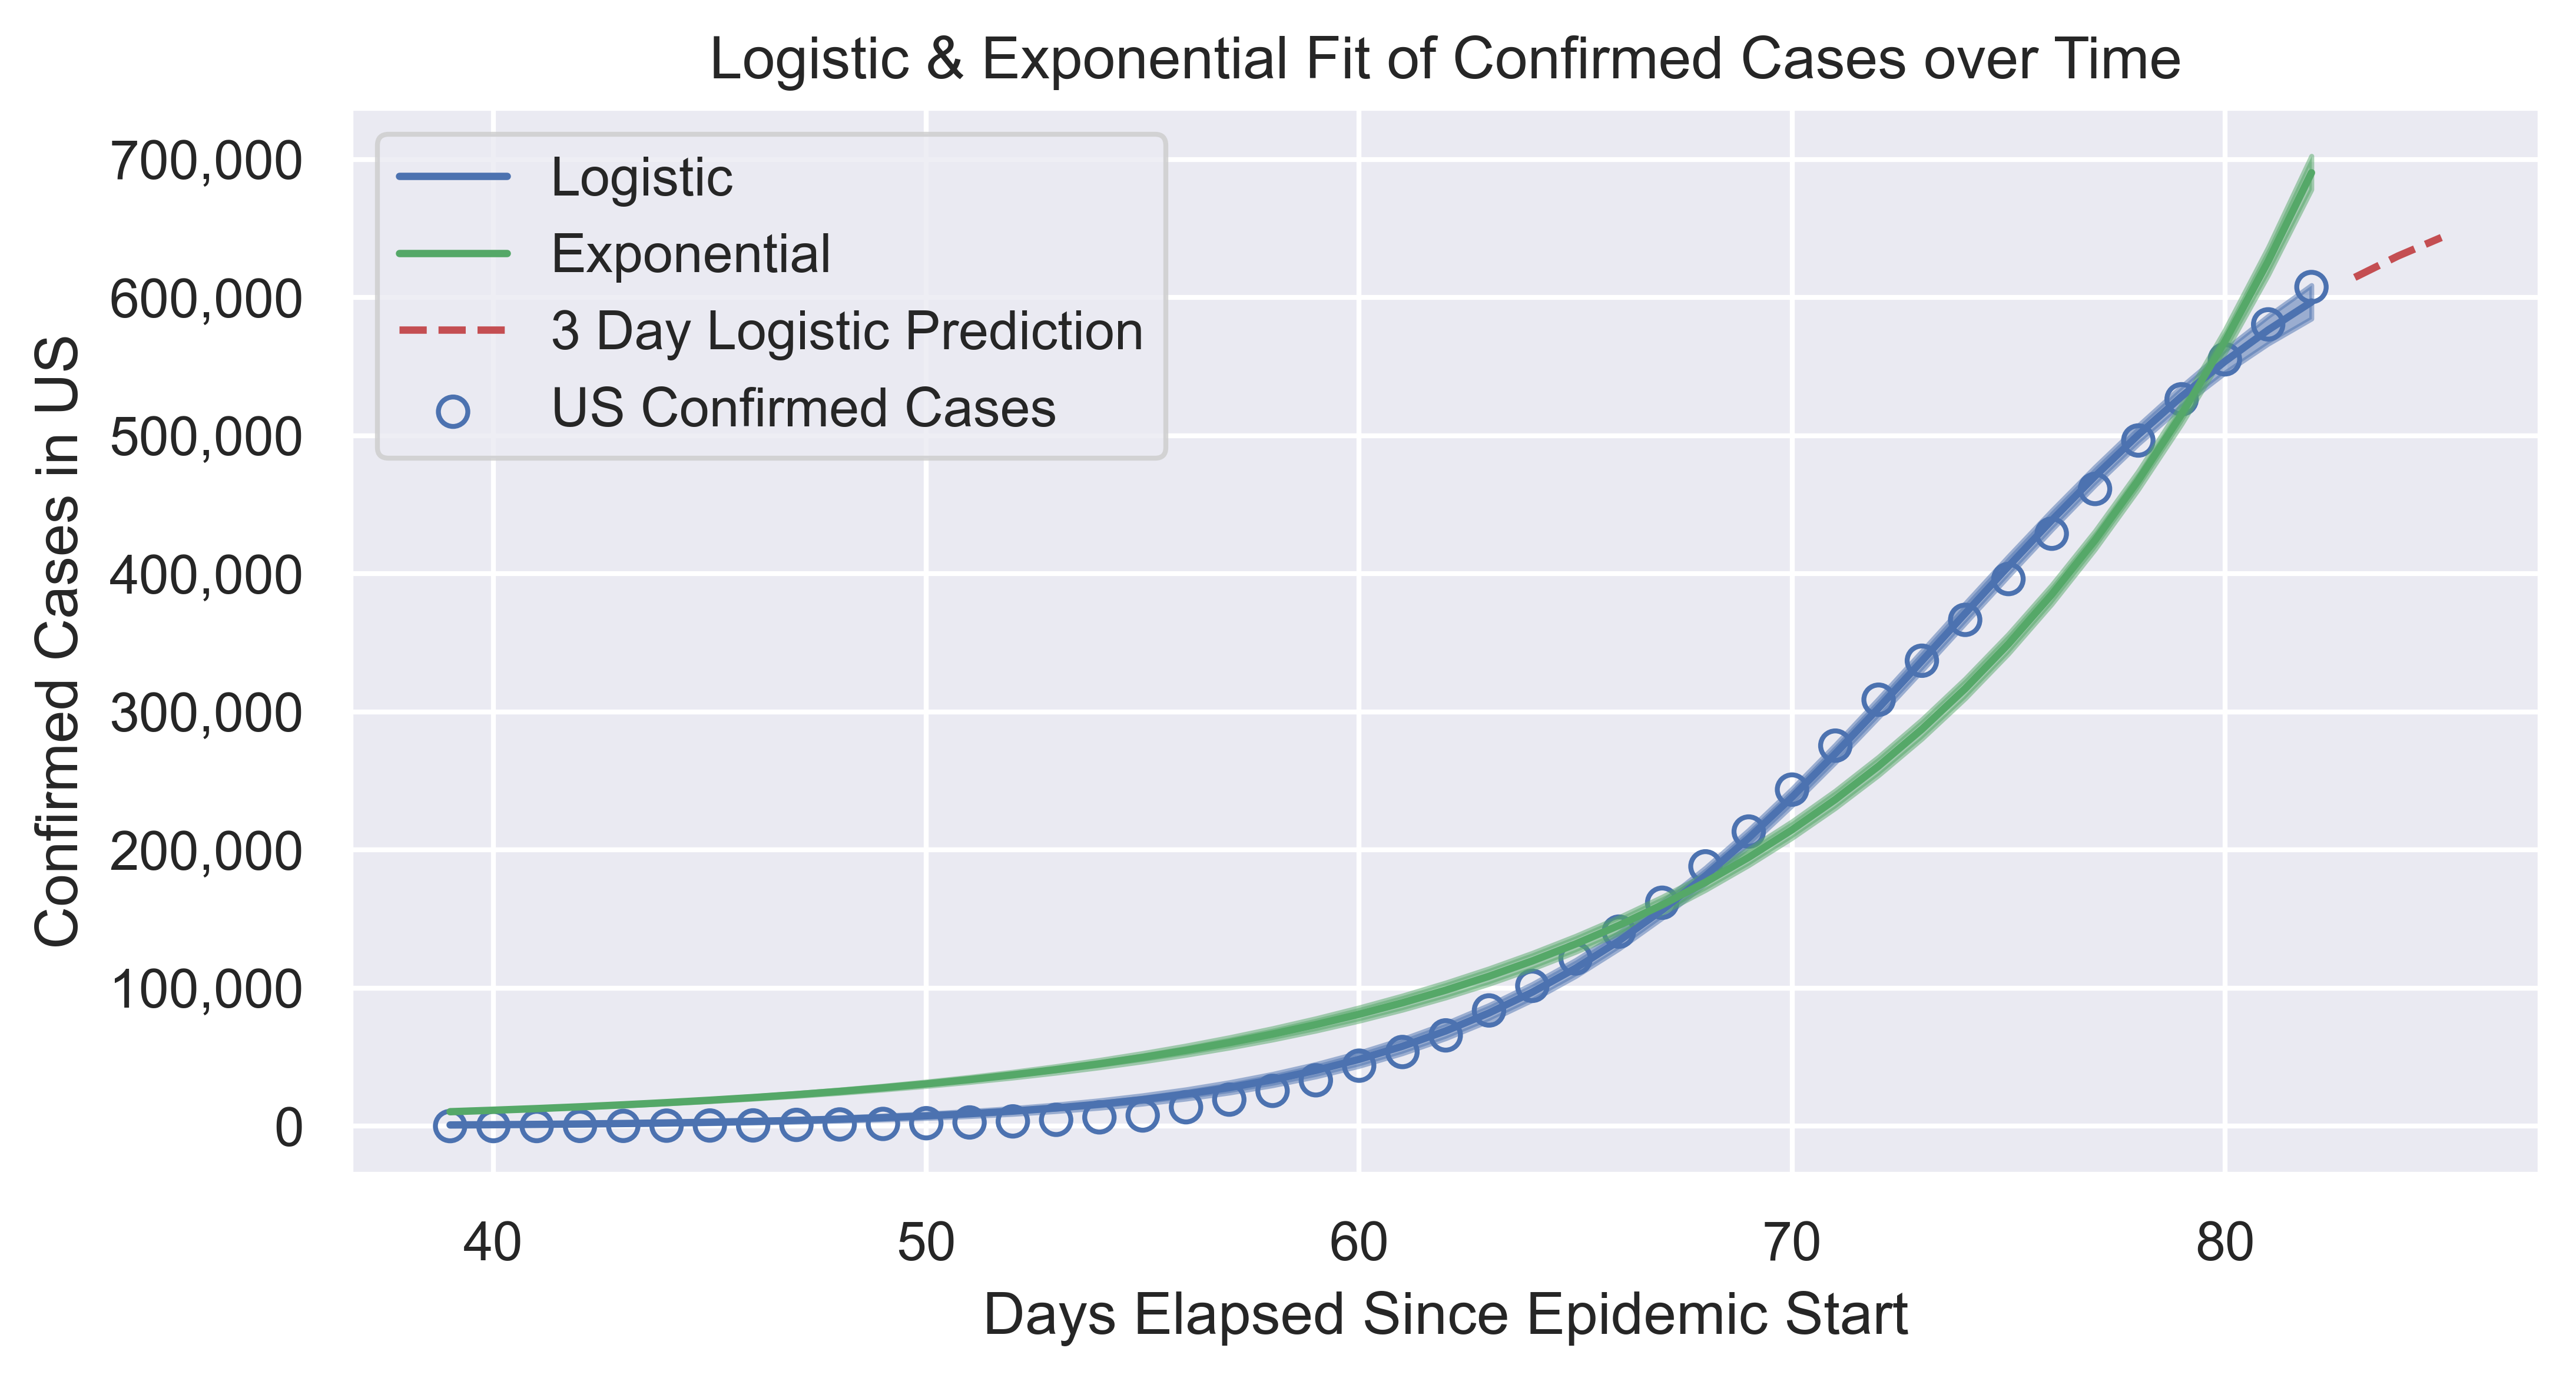

In [27]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()

ax.scatter(US_trimmed.DaysElapsed, US_trimmed.Confirmed, 
           facecolors = 'none', edgecolor = 'b', label = 'US Confirmed Cases')

ax.plot(US_trimmed.DaysElapsed, result_log.best_fit, color='b',
        label="Logistic")
ax.plot(US_trimmed.DaysElapsed, result_exp.best_fit, color='g',
        label="Exponential")

ax.plot(x_range, y_pred, '--', color = 'r', label = '{} Day Logistic Prediction'.format(d))

dely_log = result_log.eval_uncertainty(x=US_trimmed.DaysElapsed,sigma=3)
ax.fill_between(US_trimmed.DaysElapsed, 
                 result_log.best_fit-dely_log,
                 result_log.best_fit+dely_log, 
                 color='b',
                 alpha=0.5)

dely_exp = result_log.eval_uncertainty(x=US_trimmed.DaysElapsed,sigma=3)
ax.fill_between(US_trimmed.DaysElapsed, 
                 result_exp.best_fit-dely_exp,
                 result_exp.best_fit+dely_exp, 
                 color='g',
                 alpha=0.5)

# plt.yscale('log')
ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend()
ax.set_ylabel('Confirmed Cases in US')
ax.set_xlabel('Days Elapsed Since Epidemic Start')
ax.set_title('Logistic & Exponential Fit of Confirmed Cases over Time')
fig.show(warn=False)

COMPOSITE LMFIT MODELS

## SIR Theory

In [40]:
## From https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
from scipy.integrate import odeint

# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.2, 1./10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T


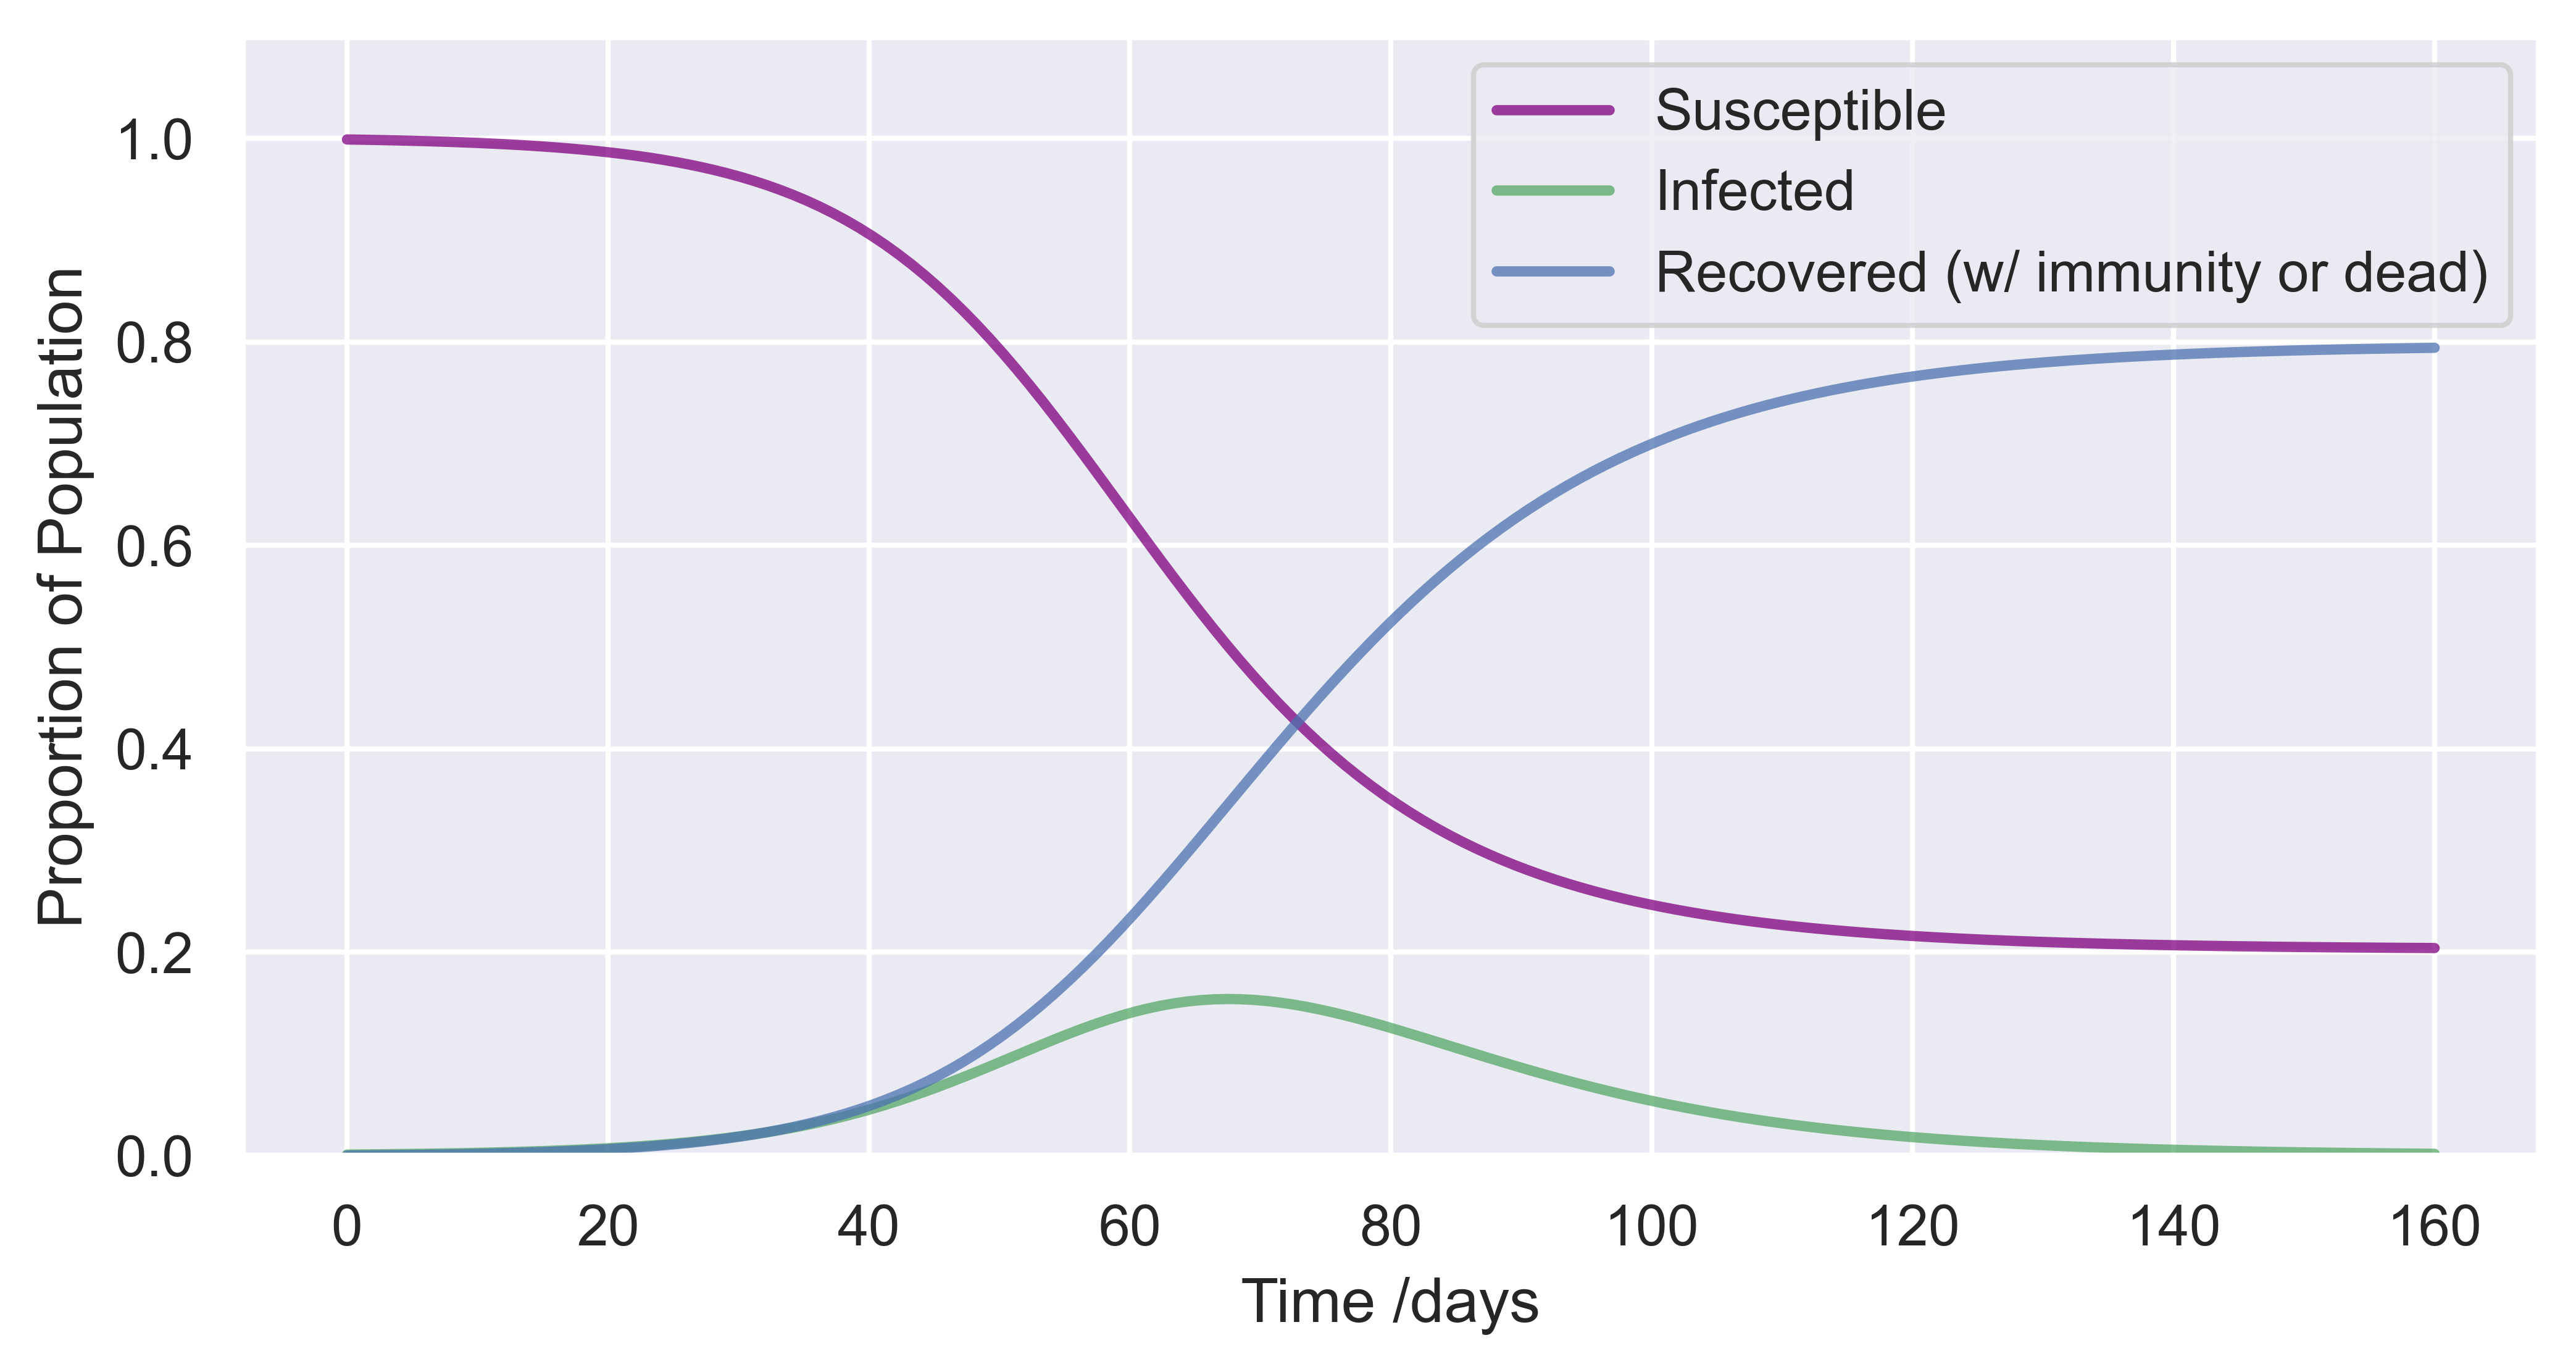

In [41]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w',figsize=(8,4))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/N, 'purple', alpha=.75, lw=2, label='Susceptible')
ax.plot(t, I/N, 'g',      alpha=.75, lw=2, label='Infected')
ax.plot(t, R/N, 'b',      alpha=.75, lw=2, label='Recovered (w/ immunity or dead)')
ax.set_xlabel('Time /days')
ax.set_ylabel('Proportion of Population')
ax.set_ylim(0,1.1)
# ax.yaxis.set_tick_params(length=0)
# ax.xaxis.set_tick_params(length=0)
# ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
# legend.get_frame().set_alpha(0.5)
# for spine in ('top', 'right', 'bottom', 'left'):
#     ax.spines[spine].set_visible(False)
plt.show()